# Cloud overview

This notebook loads and computes the overview figure seen in JGR: Atmosphers paper "Observations and model simulations of phase heterogeneity in Arctic clouds". The data used here includes post-processed hydrometeor statistics from HoloBalloon, Cloudnet target classification data, and three separate model simulations performed with WRF.

This notebook assumes preprocessed data. See file 240902_Preprocessing.ipynb for how to preprocess into the right format.

In [1]:
# Imports
import xarray as xr
import numpy as np, matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import wrf
import netCDF4 as nc
import control as ct

# Figure settings
mpl.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 12})

# Path to data locations
radiosonde_path = '/nird/projects/NS9600K/sldam/data/radiosonde_data/NYA_radiosonde_2019-11.tab'

CN_path = '/nird/projects/NS9600K/sldam/data/cloudnet_data/20191112_ny-alesund_classification.nc'
CN_raw_path = '/nird/projects/NS9600K/sldam/data/cloudnet_data/20191112_ny-alesund_rpg-fmcw-94.nc'
CN_lidar_path = '/nird/projects/NS9600K/sldam/data/cloudnet_data/lidar_cloudnet.nc'
CN_lwc_path = '/nird/projects/NS9600K/sldam/data/cloudnet_data/20191112_ny-alesund_lwc-scaled-adiabatic.nc'

HB1_path = '/nird/projects/NS9600K/sldam/data/nascent_data/HoloBalloon/HoloBalloon_t30/191112_1_t30.nc'
HB2_path = '/nird/projects/NS9600K/sldam/data/nascent_data/HoloBalloon/HoloBalloon_t30/191112_2_t30.nc'
HB3_path = '/nird/projects/NS9600K/sldam/data/nascent_data/HoloBalloon/HoloBalloon_t30/191112_3_t30.nc'

#MD3_processed_path = '/nird/projects/NS9600K/sldam/data/my_processed_data/MD3_HighRes_12Nov_IWF_CT_winddir.nc' # 1-min, IWF, wind, CT, full 12 Nov
#MA3_processed_path = '/nird/projects/NS9600K/sldam/data/my_processed_data/MA3_HighRes_12Nov_IWF_CT_winddir.nc' # 1-min, IWF, wind, CT, full 12 Nov
#MAS3_processed_path = '/nird/projects/NS9600K/sldam/data/my_processed_data/MAS3_HighRes_12Nov_IWF_CT_winddir.nc' # 1-min, IWF, wind, CT, full 12 Nov

MD3_processed_path = '/nird/projects/NS9600K/sldam/data/processed_data_no_threshold/MD3_HighRes_12Nov_IWF_CT_winddir.nc' # 1-min, IWF, wind, CT, full 12 Nov
MA3_processed_path = '/nird/projects/NS9600K/sldam/data/processed_data_no_threshold/MA3_HighRes_12Nov_IWF_CT_winddir.nc' # 1-min, IWF, wind, CT, full 12 Nov
MAS3_processed_path = '/nird/projects/NS9600K/sldam/data/processed_data_no_threshold/MAS3_HighRes_12Nov_IWF_CT_winddir.nc' # 1-min, IWF, wind, CT, full 12 Nov


# Aug 30, 24: New colors tested against color blindness  simulator
model_colors = ['#6E5CBB', '#8DC3DC', '#A64A36', '#CC793B', '#F1B872']
colors = {'Default': '#A64A36', 'Adapted': '#CC793B', 'Adapted+SIP': '#F1B872', 'CloudNet': '#8DC3DC', 'HoloBalloon': '#6E5CBB'}
phase_colors = ['#3188B9', '#5BB558', '#ACADAC']
phase_labels = ['liquid', 'mixed', 'ice']

In [2]:
# Helper functions for importing and processing the data to prepare and simplify analysis

def get_CN(datapath):
    '''
    Import the Cloudnet classification product and rename the classes relevant here

    Arguments:
    datapath  (str)            - path to location where data is stored
    Returns:
    to_ret    (xarray Dataset) - time-height xarray Dataset field with classified cloud according to Cloudnet         
    '''

    CN = xr.open_dataset(datapath).isel(height=slice(None, 350)).target_classification.transpose()
    CN = xr.where((CN != 1) & (CN != 4) & (CN != 5), x=np.nan, y=CN)

    to_ret = xr.where(CN==4, x=2, y=CN) # Ice
    to_ret = xr.where(CN==1, x=0, y=to_ret) # Liquid
    to_ret = xr.where(CN==5, x=1, y=to_ret) # Mixed
    return to_ret

def get_HB(datapath, tslice, threshold=0.1):
    '''
    Import the HoloBalloon ice water fraction data, convert time format, and classify

    Arguments:
    datapath  (str)            - path to location where data is stored
    tslice    (slice)          - slice object of the timesteps to use for analysis. This needs to be specified manually to exclude ascent/descent
    threshold (float)          - IWF thresholds used to distingish the mixed-phase zone. Default is 0.1, following Korolev et al. (2003). 
    Returns:
    to_ret    (xarray Dataset) - xarray Dataarray timeseries of classified cloud according to HoloBalloon         
    '''
    HB = xr.open_dataset(datapath).isel(time=tslice)

    times = HB.time.to_numpy()
    t = np.array([datetime.fromordinal(int(t) - 366) + timedelta(days=t%1) for t in times])
    HB['time'] = t

    IWF = HB.Ice_content / HB.Total_content
    classified = xr.where(IWF > 1 - threshold, x=2, y=IWF)
    classified = xr.where(IWF < threshold, x = 0, y=classified)
    to_ret = xr.where((IWF < 1 - threshold) & (IWF > threshold), x=1, y=classified)
    return to_ret


def get_processed_data(datapath, threshold=0.1):
    '''
    Import the WRF simulation preprocessed data and classify

    Arguments:
    datapath       (str)            - path to location where data is stored
    threshold      (float)          - IWF thresholds used to distingish the mixed-phase zone. Default is 0.1, following Korolev et al. (2003). 
    Returns:
    IWF_classified (xarray Dataset) - xarray Dataset with time/height field of classified cloud         
    '''
    x, y = 43, 50
    data = xr.open_dataset(datapath).IWF.isel(west_east=x, south_north=y)
    return classify_IWF(data, threshold=threshold)
 
def classify_IWF(IWF, threshold=0.1):
    '''Classify phase based on given IWF thresholds. Default is 0.1 and 0.9, following Korolev et al. (2003)'''
    IWF_classified = xr.where((IWF < 1-threshold) & (IWF > threshold), x=0.5, y=IWF) # mixed-phase
    IWF_classified = xr.where(IWF > 1-threshold, x=1, y=IWF_classified) # ice
    IWF_classified = xr.where(IWF < threshold, x=0, y=IWF_classified).T * 2 # liquid
    return IWF_classified

def select_layer(input, n=0, reference_level=None):
    # select nth layer counting from reference_level or top
    if reference_level is None: # Assume cloud top as reference level
        hc = xr.where(input >= 0, x=input.height, y=0)
        reference_level = hc.argmax(dim='height')
    
    return input.isel(height=reference_level - n)

In [3]:
limit_time = True # Option to use only data from when holoballoon was flying
threshold = 0.1   # Threshold for IWF to use when classifying liquid/mixed/ice.

subsample = 2           # Select only every other timestep to match resolution of model
subsample_variation = 0 # Skip the first timestep to select 'the other' subsampling alternative

#Model levels (found by wrf.getvar(nc.Dataset(MAS3_path), 'z').isel(bottom_top=slice(0, 85), west_east=50, south_north=50).to_numpy())
h = np.array([11.3408785,   34.04713,   56.80371,   79.61095, 102.47005,  125.38474,  148.3563 ,  171.38313,
    194.46507,  217.6024 ,  240.79466,  264.04178, 287.3438 ,  310.70056,  334.11267,  357.57974,
    381.10104,  404.67712,  428.30814,  451.99432, 475.73615,  499.5331 ,  523.38495,  547.292  ,
    571.2547 ,  595.27405,  619.34924,  643.4812 , 667.672  ,  691.9206 ,  716.2291 ,  740.60077,
    765.0361 ,  789.5347 ,  814.0979 ,  838.726  , 863.419  ,  888.1784 ,  913.0036 ,  937.8924 ,
    962.8429 ,  987.85596, 1012.93317, 1038.0742 , 1063.2799 , 1088.5518 , 1113.89   , 1139.2958 ,
    1164.7697 , 1190.3134 , 1220.2161 , 1254.5106 , 1288.9487 , 1323.539  , 1358.2928 , 1393.2336 ,
    1428.377  , 1463.725  , 1499.282  , 1535.0516 , 1571.0369 , 1607.2264 , 1643.6042 , 1680.1637 ,
    1716.9023 , 1753.8174 , 1790.9053 , 1828.1632 , 1865.5887 , 1903.1819 , 1940.9419 , 1978.8679 ,
    2016.9591 , 2055.214  , 2093.6353 , 2137.0706 , 2185.5688 , 2234.331  , 2283.3591 , 2332.6555 ,
    2382.2231 , 2432.0654 , 2482.1836 , 2532.5793 , 2583.2563])

#Accessing HoloBalloon data
HB_tslices = [slice(20, 136), slice(32, 191), slice(30, 274)]
HB = xr.concat([get_HB(path, tslice, threshold=threshold) for path, tslice in zip((HB1_path, HB2_path, HB3_path), HB_tslices)], dim='time')
HB = HB.isel(time=slice(subsample_variation, None, subsample))
HB_heights = xr.concat([xr.open_dataset(path).isel(time=tslice).instData_height for path, tslice in zip((HB1_path, HB2_path, HB3_path), HB_tslices)], dim='time').isel(time=slice(subsample_variation, None, subsample))


# Option to use only data from when holoballoon was flying
tslice_M = slice(None, None)
tslice_CN = slice(subsample_variation, None, subsample)
if limit_time:
    tslice_M = slice(600, 1021)
    #tslice_CN = slice(1185 + subsample_variation, 2018)
    tslice_CN = slice('2019-11-12T09:59:45', '2019-11-12T18:00:05')

CN = get_CN(CN_path).sel(time=tslice_CN).isel(time=slice(subsample_variation, None, subsample))
CN_ref = xr.open_dataset(CN_raw_path).Zh.sel(time=tslice_CN).isel(range=slice(0, 334)).resample(time='1min').mean().transpose()
CN_lidar = xr.open_dataset(CN_lidar_path).beta_raw.sel(time=tslice_CN).isel(range=slice(0, 334)).resample(time='1min').mean().transpose()
CN_lwc = xr.open_dataset(CN_lwc_path).lwc.sel(time=tslice_CN).isel(height=slice(0, 334)).resample(time='1min').mean().transpose()

MD3 = get_processed_data(MD3_processed_path, threshold=threshold).rename({'bottom_top': 'height', 'Time': 'time'}).isel(time=tslice_M)
MA3 = get_processed_data(MA3_processed_path, threshold=threshold).rename({'bottom_top': 'height', 'Time': 'time'}).isel(time=tslice_M)
MAS3 = get_processed_data(MAS3_processed_path, threshold=threshold).rename({'bottom_top': 'height', 'Time': 'time'}).isel(time=tslice_M)

#Radiosonde
names = ['time', 'latitude', 'longitude', 'altitude', 'h geom [m]', 'ETIM [s]', 'pressure', 'temperature', 'RH', 'dp', 'ff [m/s]']

df_raw = pd.read_csv(radiosonde_path, sep='\t', skiprows=range(1, 92284), nrows=21136, names=names).drop(0)
df = df_raw[['altitude', 'pressure', 'temperature']]

RS1 = df[:1000].set_index(pd.DatetimeIndex(df_raw['time'][:1000].values)).resample('1s').mean()
RS2 = df[7177:8177].set_index(pd.DatetimeIndex(df_raw['time'][7177:8177].values)).resample('1s').mean()
RS3 = df[14167:15167].set_index(pd.DatetimeIndex(df_raw['time'][14167:15167].values)).resample('1s').mean()

In [4]:
MD3_path = '/nird/projects/NS9600K/brittsc/240312_Morr_default_high_time_res_output/wrfout_d03_2019-11-12_04:40:00'
MA3_path = '/nird/projects/NS9600K/brittsc/240311_Morr2_high_time_res_output/wrfout_d03_2019-11-12_08:00:00'
MAS3_path = '/nird/projects/NS9600K/brittsc/240203_Morr5_corrected_SST_high_time_res_output/wrfout_d03_2019-11-12_08:00:00'

MD3_full = xr.open_dataset(MD3_path).isel(
    bottom_top=slice(0, 85), bottom_top_stag=slice(0, 85),
    west_east=43, south_north=50,
    west_east_stag=43, south_north_stag=50,
    Time=slice(320, 800))
MA3_full = xr.open_dataset(MA3_path).isel(
    bottom_top=slice(0, 85), bottom_top_stag=slice(0, 85),
    west_east=43, south_north=50,
    west_east_stag=43, south_north_stag=50,
    Time=slice(120, None))
MAS3_full = xr.open_dataset(MAS3_path).isel(
    bottom_top=slice(0, 85), bottom_top_stag=slice(0, 85),
    west_east=43, south_north=50,
    west_east_stag=43, south_north_stag=50,
    Time=slice(120, None))


In [5]:
def TWC(data):
    TWC = data.QCLOUD + data.QRAIN + data.QGRAUP + data.QSNOW + data.QICE # kg / kg
    TWC = TWC * 1000 # g / kg

    P = data.P + data.PB # Pressure
    theta = data.T + 300
    T = theta * (P / 100000) ** 0.2854 # Potential temp equation

    TWC = TWC * P  / (287.058 * T) #ideal gas law

    return TWC, T # g/m3, K

TWC_MD3, T_MD3 = TWC(MD3_full)
TWC_MA3, T_MA3 = TWC(MA3_full)
TWC_MAS3, T_MAS3 = TWC(MAS3_full)

In [ ]:
HB_tot = xr.open_mfdataset([HB1_path, HB2_path, HB3_path])
HB_tot['time'] = pd.to_datetime(HB_tot.time - 719529, unit='D')

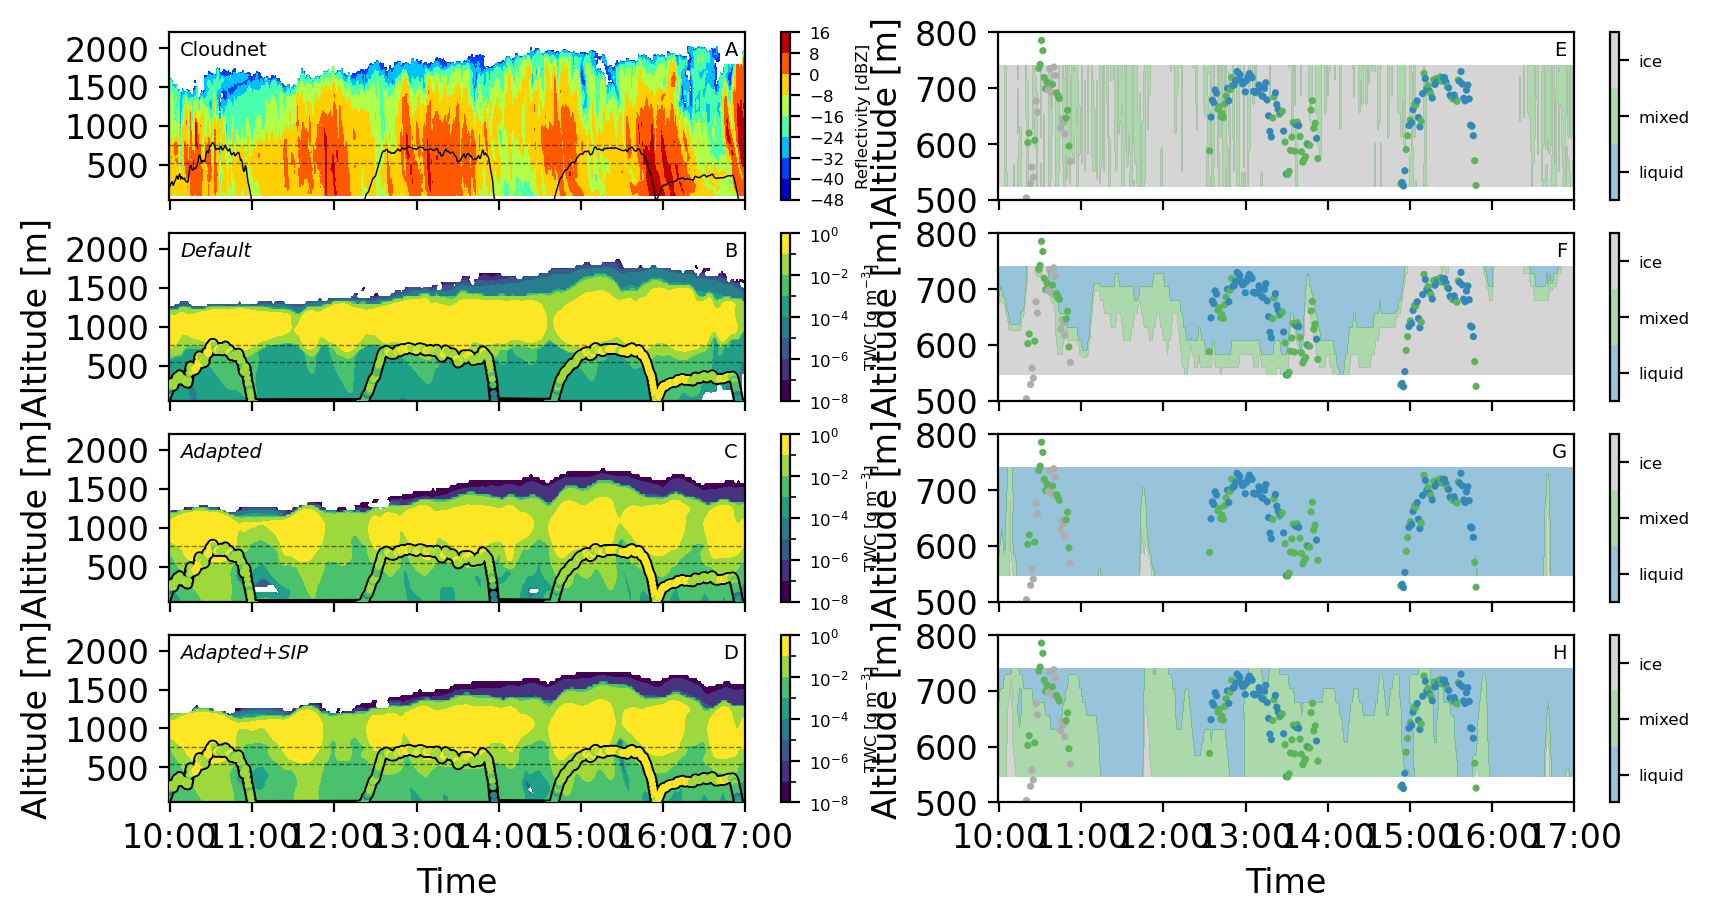

In [9]:
fig, ax = plt.subplots(4, 2, sharex=True, sharey=False, figsize=(10, 5))
plt.rcParams.update({'font.size': 6})



T, H = np.meshgrid(TWC_MD3.XTIME, h)

lo = -8
threshold = 10**(lo)

cmap = plt.cm.viridis
bounds = np.logspace(lo, 0, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


p1 = ax[1, 0].contourf(T, H, TWC_MD3.where(TWC_MD3 > threshold, other=np.nan).values.T, levels=bounds, norm=norm)

p2 = ax[2, 0].contourf(T, H, TWC_MA3.where(TWC_MA3 > threshold, other=np.nan).values.T, levels=bounds, norm=norm)

p3 = ax[3, 0].contourf(T, H, TWC_MAS3.where(TWC_MAS3 > threshold, other=np.nan).values.T, levels=bounds, norm=norm)



height_slice = slice(32-9, 32)
T, H = np.meshgrid(MD3.XTIME, h[32-9:32])
p = ax[1, 1].contourf(T, H, MD3.isel(height=height_slice), colors=phase_colors, levels=[-0.5, 0.5, 1.5, 2.5], alpha=0.5)
cb = fig.colorbar(p, ax=ax[1, 1], ticks=[0, 1, 2])
cb.set_ticklabels(['liquid', 'mixed', 'ice'])

p = ax[2, 1].contourf(T, H, MA3.isel(height=height_slice), colors=phase_colors, levels=[-0.5, 0.5, 1.5, 2.5], alpha=0.5)
cb = fig.colorbar(p, ax=ax[2, 1], ticks=[0, 1, 2])
cb.set_ticklabels(['liquid', 'mixed', 'ice'])

p = ax[3, 1].contourf(T, H, MAS3.isel(height=height_slice), colors=phase_colors, levels=[-0.5, 0.5, 1.5, 2.5], alpha=0.5)
cb = fig.colorbar(p, ax=ax[3, 1], ticks=[0, 1, 2])
cb.set_ticklabels(['liquid', 'mixed', 'ice'])






T, H = np.meshgrid(CN_ref.time, CN_ref.range)
pRef = ax[0, 0].contourf(T, H, CN_ref, cmap='jet')
fig.colorbar(pRef, ax=ax[0, 0], label='Reflectivity [dBZ]')

#pLwc = ax[0, 0].contourf(T, H, CN_lwc.where(CN_lwc > 10**(-4)), cmap='viridis')
#fig.colorbar(pLwc, ax=ax[0, 0], label='Reflectivity [dBZ]')

T, H = np.meshgrid(CN.time, CN.isel(height=slice(137-30, 137)).height)
p = ax[0, 1].contourf(T, H, CN.isel(height=slice(137-30, 137)), levels=[-0.5, 0.5, 1.5, 2.5], colors=phase_colors, alpha=0.5)
cb = fig.colorbar(p, ax=ax[0, 1], ticks=[0, 1, 2])
cb.set_ticklabels(['liquid', 'mixed', 'ice'])



ax[0, 0].plot(HB_tot.time, HB_tot.instData_height, color='k', alpha=1, linewidth=0.51)
for x in ax[1:, 0]:
    x.plot(HB_tot.time, HB_tot.instData_height, c='k', alpha=1, linewidth=4, zorder=10)
    x.scatter(HB_tot.time, HB_tot.instData_height, c=HB_tot.Total_content, alpha=1, s=2.5, norm=norm, zorder=111)#, edgecolor='k', linewidths=0.1)
    x.set_ylabel('Altitude [m]')

[x.set_ylim(50, 2200) for x in ax[:, 0]]

for x in ax[:, 1]:
    x.scatter(HB.time, HB_heights, c=[phase_colors[int(i)] for i in HB.values], alpha=1, s=2.5)#, edgecolor='k', linewidths=0.1)
    x.set_ylabel('Altitude [m]')
    x.set_ylim(500, 800)


for x in ax.flatten():
    x.set_xlabel('')


ax[0, 0].axhline(CN.height[137], color='k', linestyle='dashed', linewidth=0.5, alpha=0.5)
ax[0, 0].axhline(CN.height[137-30], color='k', linestyle='dashed', linewidth=0.5, alpha=0.5)

for x in ax[1:, 0].flatten():
    x.axhline(h[32], color='k', linestyle='dashed', linewidth=0.5, alpha=0.5)
    x.axhline(h[32-9], color='k', linestyle='dashed', linewidth=0.5, alpha=0.5)

for x in ax[3, :]:
    x.set_xlabel('Time')
    x.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))

ax[0, 0].text(0.02, 0.95, 'Cloudnet', transform=ax[0, 0].transAxes, fontsize=7, 
            va='top', ha='left', rotation=0)

ax[1, 0].text(0.02, 0.95, 'Default', transform=ax[1, 0].transAxes, fontsize=7, 
            va='top', ha='left', rotation=0, fontstyle='italic')

ax[2, 0].text(0.02, 0.95, 'Adapted', transform=ax[2, 0].transAxes, fontsize=7, 
            va='top', ha='left', rotation=0, fontstyle='italic')

ax[3, 0].text(0.02, 0.95, 'Adapted+SIP', transform=ax[3, 0].transAxes, fontsize=7, 
            va='top', ha='left', rotation=0, fontstyle='italic')

ax[0, 0].text(0.987, 0.95, 'A', transform=ax[0, 0].transAxes, fontsize=7, backgroundcolor='white', zorder=1, bbox={'pad':0.8, 'facecolor': 'white', 'edgecolor': 'white'},
            va='top', ha='right')

ax[1, 0].text(0.987, 0.95, 'B', transform=ax[1, 0].transAxes, fontsize=7, 
            va='top', ha='right')

ax[2, 0].text(0.987, 0.95, 'C', transform=ax[2, 0].transAxes, fontsize=7, 
            va='top', ha='right')

ax[3, 0].text(0.987, 0.95, 'D', transform=ax[3, 0].transAxes, fontsize=7, 
            va='top', ha='right')

ax[0, 1].text(0.987, 0.95, 'E', transform=ax[0, 1].transAxes, fontsize=7, backgroundcolor='white', zorder=1, bbox={'pad':0.8, 'facecolor': 'white', 'edgecolor': 'white'},
            va='top', ha='right')

ax[1, 1].text(0.987, 0.95, 'F', transform=ax[1, 1].transAxes, fontsize=7, 
            va='top', ha='right')

ax[2, 1].text(0.987, 0.95, 'G', transform=ax[2, 1].transAxes, fontsize=7, 
            va='top', ha='right')

ax[3, 1].text(0.987, 0.95, 'H', transform=ax[3, 1].transAxes, fontsize=7, 
            va='top', ha='right')

cb1 = fig.colorbar(p1, ax=ax[1, 0], ticks=np.logspace(lo, 0, 5), label='TWC [g m$^{-3}$]')
cb1.ax.set_yticklabels([f'$10^{{{np.log10(b):.0f}}}$' for b in np.logspace(lo, 0, 5)])
cb2 = fig.colorbar(p2, ax=ax[2, 0], ticks=np.logspace(lo, 0, 5), label='TWC [g m$^{-3}$]')
cb2.ax.set_yticklabels([f'$10^{{{np.log10(b):.0f}}}$' for b in np.logspace(lo, 0, 5)])
cb3 = fig.colorbar(p3, ax=ax[3, 0], ticks=np.logspace(lo, 0, 5), label='TWC [g m$^{-3}$]')
cb3.ax.set_yticklabels([f'$10^{{{np.log10(b):.0f}}}$' for b in np.logspace(lo, 0, 5)])

ax[0, 0].set_xlim(CN_ref.time[0], CN_ref.time[-60])
plt.subplots_adjust(wspace=0.15)


[Text(1, 0.0001, '$10^{-4}$'),
 Text(1, 0.001, '$10^{-3}$'),
 Text(1, 0.01, '$10^{-2}$'),
 Text(1, 0.1, '$10^{-1}$'),
 Text(1, 1.0, '$10^{0}$')]

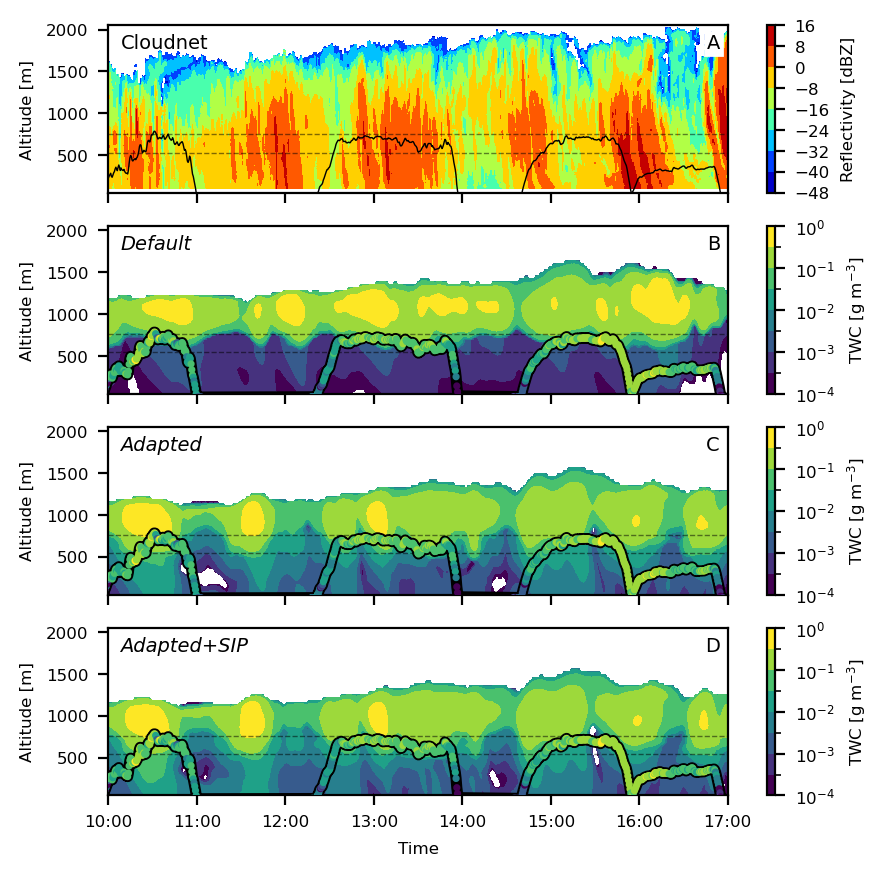

In [10]:
fig, ax = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(5, 5))
plt.rcParams.update({'font.size': 6})



T, H = np.meshgrid(TWC_MD3.XTIME, h)

lo = -4
threshold = 10**(lo)

cmap = plt.cm.viridis
bounds = np.logspace(lo, 0, 9)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


p1 = ax[1].contourf(T, H, TWC_MD3.where(TWC_MD3 > threshold, other=np.nan).values.T, levels=bounds, norm=norm)

p2 = ax[2].contourf(T, H, TWC_MA3.where(TWC_MA3 > threshold, other=np.nan).values.T, levels=bounds, norm=norm)

p3 = ax[3].contourf(T, H, TWC_MAS3.where(TWC_MAS3 > threshold, other=np.nan).values.T, levels=bounds, norm=norm)






T, H = np.meshgrid(CN_ref.time, CN_ref.range)
p = ax[0].contourf(T, H, CN_ref, cmap='jet')
fig.colorbar(p, ax=ax[0], label='Reflectivity [dBZ]')
ax[0].plot(HB_tot.time, HB_tot.instData_height, color='k', alpha=1, linewidth=0.51)


for x in ax[1:]:
    x.plot(HB_tot.time, HB_tot.instData_height, c='k', alpha=1, linewidth=4, zorder=10)
    #x.scatter(HB_tot.time, HB_tot.instData_height, c='k', alpha=1, s=6.5)
    x.scatter(HB_tot.time, HB_tot.instData_height, c=HB_tot.Total_content, alpha=1, s=2.5, norm=norm, zorder=100)#, edgecolor='k', linewidths=0.1)    

for x in ax:
    x.set_xlabel('')
    x.set_ylabel('Altitude [m]')
    x.set_ylim(50, 2050)


ax[0].axhline(CN.height[137], color='k', linestyle='dashed', linewidth=0.5, alpha=0.5)
ax[0].axhline(CN.height[137-30], color='k', linestyle='dashed', linewidth=0.5, alpha=0.5)

for x in ax[1:]:
    x.axhline(h[32], color='k', linestyle='dashed', linewidth=0.5, alpha=0.5)
    x.axhline(h[32-9], color='k', linestyle='dashed', linewidth=0.5, alpha=0.5)

ax[3].set_xlabel('Time')
ax[3].xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))

ax[0].text(0.02, 0.95, 'Cloudnet', transform=ax[0].transAxes, fontsize=7, 
            va='top', ha='left', rotation=0)

ax[1].text(0.02, 0.95, 'Default', transform=ax[1].transAxes, fontsize=7, 
            va='top', ha='left', rotation=0, fontstyle='italic')

ax[2].text(0.02, 0.95, 'Adapted', transform=ax[2].transAxes, fontsize=7, 
            va='top', ha='left', rotation=0, fontstyle='italic')

ax[3].text(0.02, 0.95, 'Adapted+SIP', transform=ax[3].transAxes, fontsize=7, 
            va='top', ha='left', rotation=0, fontstyle='italic')

ax[0].text(0.987, 0.95, 'A', transform=ax[0].transAxes, fontsize=7, backgroundcolor='white', zorder=1, bbox={'pad':0.8, 'facecolor': 'white', 'edgecolor': 'white'},
            va='top', ha='right')

ax[1].text(0.987, 0.95, 'B', transform=ax[1].transAxes, fontsize=7, 
            va='top', ha='right')

ax[2].text(0.987, 0.95, 'C', transform=ax[2].transAxes, fontsize=7, 
            va='top', ha='right')

ax[3].text(0.987, 0.95, 'D', transform=ax[3].transAxes, fontsize=7, 
            va='top', ha='right')

plt.subplots_adjust(wspace=0.1)
ax[0].set_xlim(CN.time[0], CN.time[-59])

cb1 = fig.colorbar(p1, ax=ax[1], ticks=np.logspace(lo, 0, 5), label='TWC [g m$^{-3}$]')
cb1.ax.set_yticklabels([f'$10^{{{np.log10(b):.0f}}}$' for b in np.logspace(lo, 0, 5)])
cb2 = fig.colorbar(p2, ax=ax[2], ticks=np.logspace(lo, 0, 5), label='TWC [g m$^{-3}$]')
cb2.ax.set_yticklabels([f'$10^{{{np.log10(b):.0f}}}$' for b in np.logspace(lo, 0, 5)])
cb3 = fig.colorbar(p3, ax=ax[3], ticks=np.logspace(lo, 0, 5), label='TWC [g m$^{-3}$]')
cb3.ax.set_yticklabels([f'$10^{{{np.log10(b):.0f}}}$' for b in np.logspace(lo, 0, 5)])

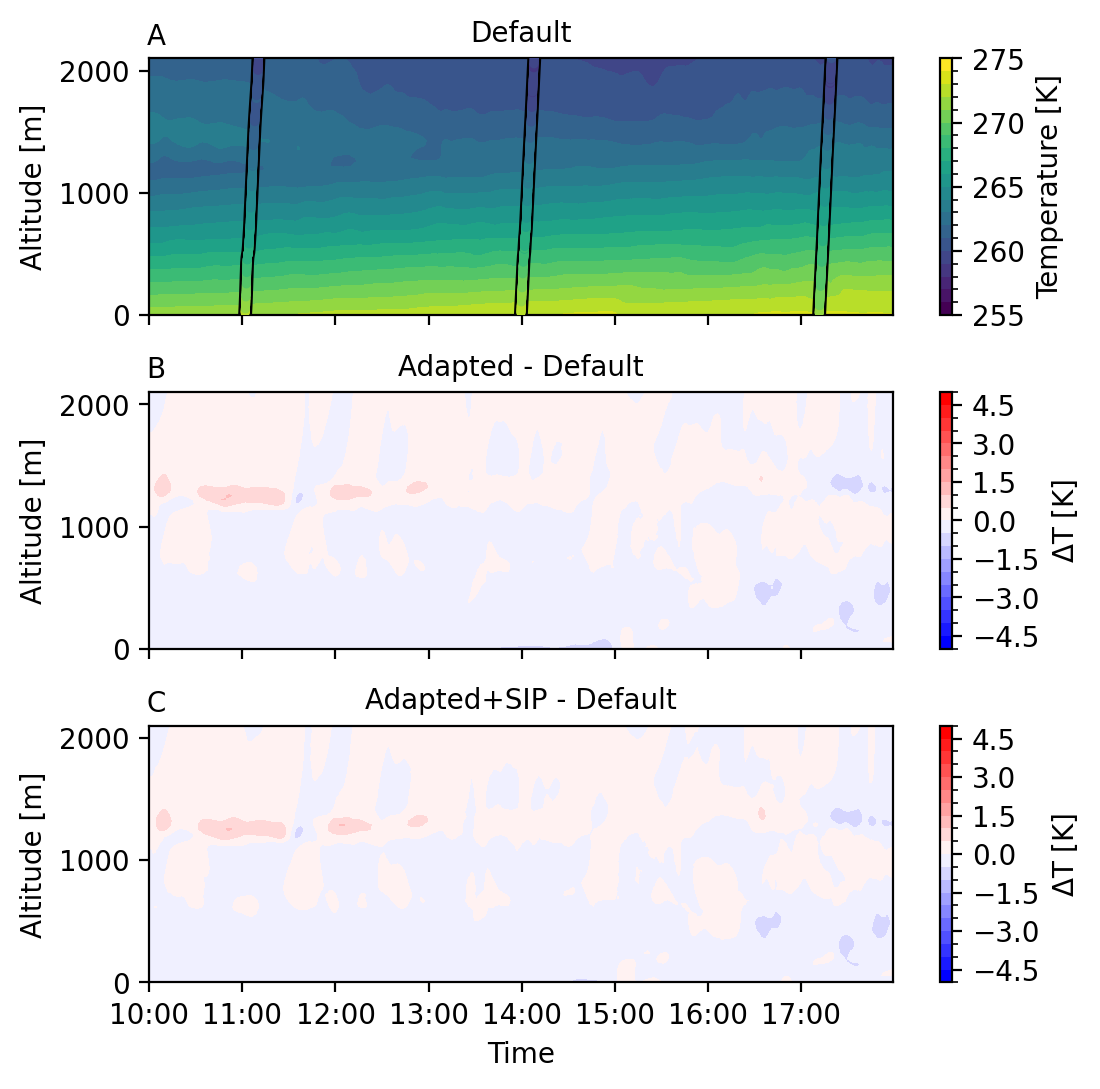

In [38]:

fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})

cmap = plt.cm.viridis
bounds = np.arange(255, 276, 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

T, H = np.meshgrid(T_MD3.XTIME, h)
p = ax[0].contourf(T, H, T_MD3.T, cmap='viridis', levels=bounds, norm=norm)
fig.colorbar(p, ax=ax[0], label='Temperature [K]', ticks=np.arange(255, 281, 5))

ax[0].set_title('Default', fontsize=10)

for rs in [RS1, RS2, RS3]:
    ax[0].plot(rs.index, rs.altitude, c='k', linewidth=5, zorder=10)
    ax[0].scatter(rs.index, rs.altitude, c=rs.temperature + 273.15, zorder=100, norm=norm, cmap=cmap, s=5)



cmap = plt.cm.bwr
bounds = np.arange(-5, 5.1, 0.5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

p = ax[1].contourf(T, H, T_MA3.T - T_MD3.T, cmap=cmap, levels=bounds, norm=norm)
fig.colorbar(p, ax=ax[1], label='$\Delta$T [K]')#, ticks=[-2, -1, 0, 1, 2])
ax[1].set_title('Adapted - Default', fontsize=10)

p = ax[2].contourf(T, H, T_MAS3.T - T_MD3.T, cmap=cmap, levels=bounds, norm=norm)
fig.colorbar(p, ax=ax[2], label='$\Delta$T [K]')#, ticks=[-2, -1, 0, 1, 2])
ax[2].set_title('Adapted+SIP - Default', fontsize=10)
plt.subplots_adjust(hspace=0.3)

ax[2].set_xlabel('Time')
ax[2].xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
[x.set_ylabel('Altitude [m]') for x in ax]


ax[0].text(0.022, 1.14, 'A', transform=ax[0].transAxes, fontsize=10, 
            va='top', ha='right')

ax[1].text(0.022, 1.14, 'B', transform=ax[1].transAxes, fontsize=10, 
            va='top', ha='right')

ax[2].text(0.022, 1.14, 'C', transform=ax[2].transAxes, fontsize=10, 
            va='top', ha='right')


ax[0].set_ylim(0, 2100)
#ax[0].set_xlim(T_MD3.XTIME[0], T_MD3.XTIME[-1])
plt.show()